In [7]:
# Import libraries
import numpy as np
import pandas as pd
import chromadb
from chromadb.utils import embedding_functions
from sentence_transformers import SentenceTransformer
import json
import umap
from sklearn.decomposition import PCA
from scipy import stats
import matplotlib.pyplot as plt

In [8]:
# Load data into a pandas DataFrame
import pandas as pd
df = pd.read_csv('../data/WVS Statements.csv')
df

,id,Statement,Code,WVS question
0,001-01,Family is very important in my life.,1,Q1
1,001-02,Family is rather important in my life.,2,Q1
2,001-03,Family is not very important in my life.,3,Q1
3,001-04,Family is not at all important in my life.,4,Q1
4,002-01,Friends are very important in my life.,1,Q2
...,...,...,...,...
909,300-01,I feel the political system gives people like ...,1,SDG1
910,300-02,I feel the political system gives people like ...,2,SDG1
911,300-03,I feel the political system gives people like ...,3,SDG1
912,300-04,I feel the political system gives people like ...,4,SDG1


In [45]:
#model_name = "intfloat/multilingual-e5-large-instruct"
#model_name = "all-MiniLM-L6-v2"
#model_name = "allenai/specter"
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

# Load model
embedding_model = SentenceTransformer(model_name)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 2087.60it/s, Materializing param=pooler.dense.weight]                               
XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [46]:
# Selct one question as a test
df_test = df[df['WVS question'] == 'Q90']
df_test

,id,Statement,Code,WVS question
243,090-01,International organizations must prioritize ef...,1,Q90
244,090-02,International organizations should be primaril...,2,Q90
245,090-03,International organizations should lean toward...,3,Q90
246,090-04,International organizations should focus more ...,4,Q90
247,090-05,International organizations should balance eff...,5,Q90
248,090-06,International organizations should balance eff...,6,Q90
249,090-07,International organizations should generally r...,7,Q90
250,090-08,International organizations should be primaril...,8,Q90
251,090-09,International organizations should firmly upho...,9,Q90
252,090-10,International organizations must be fully demo...,10,Q90


In [47]:
# Compute embeddings for the selected question
embeddings = embedding_model.encode(df_test['Statement'].tolist())

In [48]:
# Initialize PCA
pca = PCA(n_components=1, random_state=42)

# Fit PCA to embeddings and transform the data
pca_result = pca.fit_transform(embeddings)

In [49]:
# Create a DataFrame for plotting from PCA results and add metadata
pca_df = pd.DataFrame(data = pca_result, columns = ['Embedded value'])
pca_df['text'] = df_test['Statement'].reset_index(drop=True)
pca_df['Target value'] = df_test['Code'].reset_index(drop=True)

In [50]:
# Normalize column 'Embedded value' values to minimize the distance with 'Target value' values using a linear regression
ratio, constant, r_value, p_value, std_err = stats.linregress(pca_df['Embedded value'], pca_df['Target value'])
pca_df['Normalized embedded value'] = ratio * pca_df['Embedded value'] + constant

# Delete 'Embedded value' column
pca_df = pca_df.drop(columns=['Embedded value'])
pca_df.head()

,text,Target value,Normalized embedded value
0,International organizations must prioritize ef...,1,6.080596
1,International organizations should be primaril...,2,5.987516
2,International organizations should lean toward...,3,4.758841
3,International organizations should focus more ...,4,5.357191
4,International organizations should balance eff...,5,4.741093


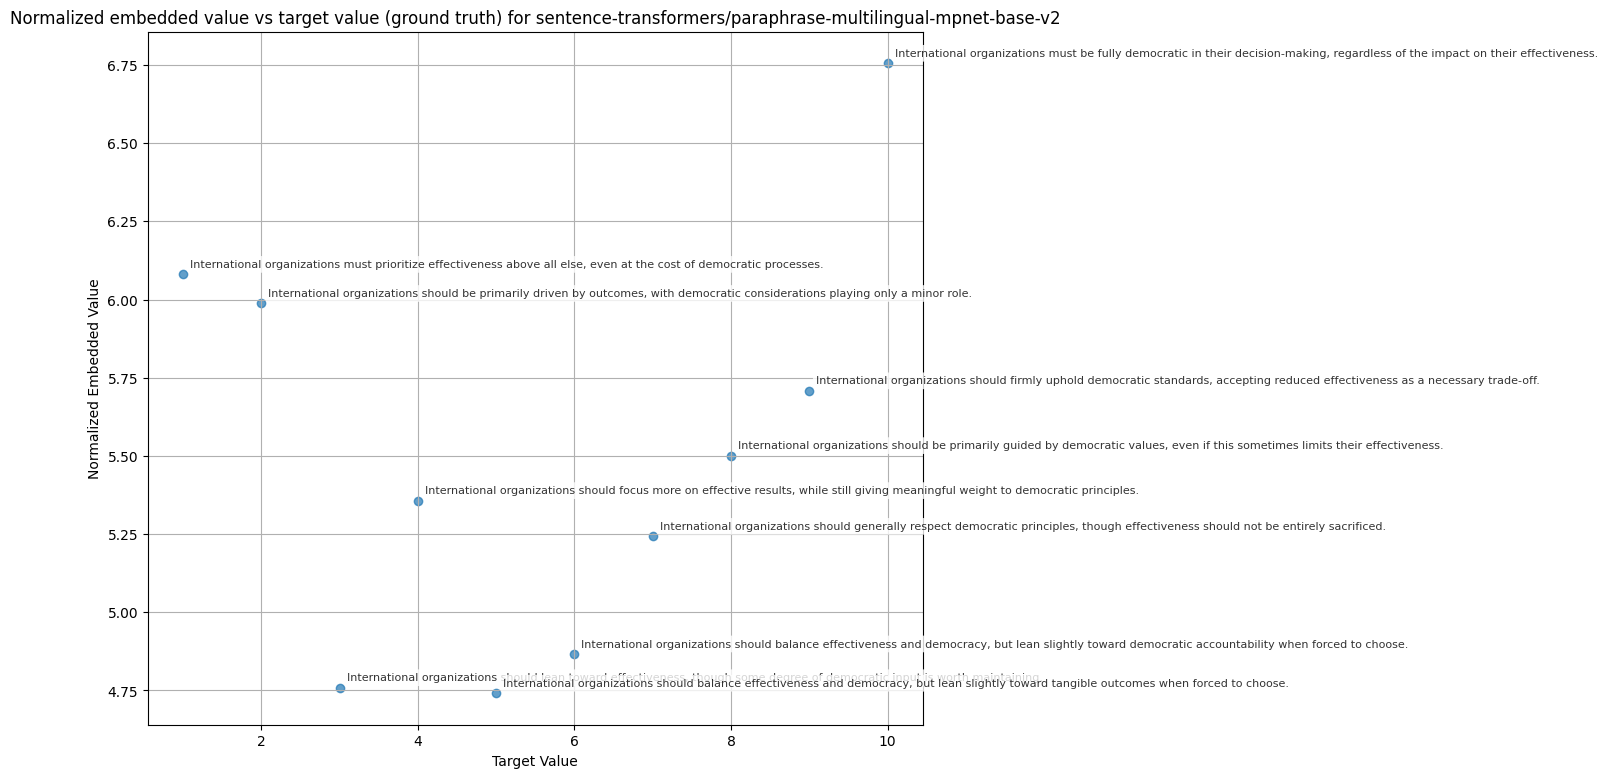

In [51]:
# Plot result
plt.figure(figsize=(10, 9))
plt.scatter(pca_df['Target value'], pca_df['Normalized embedded value'], alpha=0.7)

# Add labels to a subset of points to avoid overlap
# Select points at regular intervals (every Nth point)
n = len(pca_df)
label_every = max(1, n // 15)  # Label approximately 15 points

for i in range(0, n, label_every):
    plt.annotate(pca_df.iloc[i]['text'], 
                 (pca_df.iloc[i]['Target value'], pca_df.iloc[i]['Normalized embedded value']),
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=8, alpha=0.8,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

plt.title('Normalized embedded value vs target value (ground truth) for '+model_name)
plt.xlabel('Target Value')
plt.ylabel('Normalized Embedded Value')
plt.grid()
plt.show()

In [52]:
# Compute the spearman correlation
correlation, p_value = stats.spearmanr(pca_df['Target value'], pca_df['Normalized embedded value'])
print(f"Spearman correlation: {correlation:.4f}, p-value: {p_value:.4f}")

Spearman correlation: 0.1273, p-value: 0.7261
